In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import folktables
from folktables import ACSDataSource, ACSEmployment

from sklearn.preprocessing import PolynomialFeatures

In [2]:
def has_converged(x, size, epsilon):
    for i in range(0,size):
            if np.linalg.norm(x[-1:][0] - x[-(2+i):][0], np.inf) > epsilon:
                return False
    return True

In [3]:
def linear_proxies(x, y, z, iters, epsilon, eta_val = None, non_disclosive=False, MSE=False):
    n = x.shape[0]
    theta = [LinearRegression(fit_intercept=False).fit(x,z).coef_.reshape(-1,1)]
    theta_average = [LinearRegression(fit_intercept=False).fit(x,z).coef_.reshape(-1,1)]
    z_sum = np.sum(z)
    grad_term_overall = np.sum(x, axis=0)/z_sum
    converged = False
    
    if eta_val:
        eta = eta_val
        
    print("Iterations:")    
    for t in range(1, iters):
        if eta_val is None:
            eta = 1/(np.sqrt(n*t))
            
        if t%200 == 0:
            print(t)
        
        zhat = np.matmul(x,theta[t-1])
        costs = (zhat-z)*(1-2*y)
        
        prc = LinearRegression(fit_intercept=False).fit(x,costs)
        h_real = prc.predict(x)
        h_plus = h_real > 0
        h_minus = h_real < 0
    
        if np.sum(costs[h_plus]) > -np.sum(costs[h_minus]):
            h = h_plus
        else:
            h = h_minus
            
        h = h.astype(int)
        zhat_sum = np.sum(zhat)
        err_points = np.abs(h-y)
        
        err_cost = np.squeeze(np.matmul((zhat-z).T,err_points))/z_sum
        overall_diff = zhat_sum/z_sum - 1

        if np.abs(overall_diff) >= np.abs(err_cost):           
            penalty = np.sign(overall_diff) * grad_term_overall
        else:
            penalty = np.sign(err_cost) * np.matmul(np.transpose(x),err_points)/z_sum
        
        #breakpoint()
        #New dot product objective
        if non_disclosive:
            dot_objective = np.matmul(np.transpose(x),z)/n
            penalty = penalty.reshape(-1,1) + dot_objective.reshape(-1,1)
        elif MSE:
            objective = 2*np.matmul(np.transpose(x),(zhat-z))/n
            penalty = penalty.reshape(-1,1) + objective.reshape(-1,1)
        else:
            penalty = penalty.reshape(-1,1)
        
        new_theta = theta[t-1] - eta*penalty
        #new_theta = theta[t-1] - eta*penalty.reshape(-1,1)
        theta.append(new_theta)
        theta_average.append((t*theta_average[t-1]+new_theta)/(t+1))
        
        if t%100 == 0 :
            if has_converged(theta_average, 10, epsilon):
                converged = True
                break
                    
    return theta, theta_average[-1]   

In [4]:
def evaluate_proxy(x, y, z, theta_average):
    n = x.shape[0]
    zhat = np.matmul(x, theta_average) 
    final_costs = (zhat-z)*(1-2*y)
    prc = LinearRegression(fit_intercept=False).fit(x, final_costs)  
    h_real = prc.predict(x)
    h_plus = h_real > 0
    h_minus = h_real < 0
    
    if np.sum(h_real[h_plus]) > -np.sum(h_real[h_minus]):
        h = h_plus
    else:
        h = h_minus
    
    h = h.astype(int)    
       
    zhat_sum = np.sum(zhat)
    z_sum = np.sum(z)
    err_points = np.abs(h-y)

    err_cost_z = np.squeeze(np.matmul(z.T, err_points))
    err_cost_zhat = np.squeeze(np.matmul(zhat.T, err_points))
    overall_diff = zhat_sum/z_sum - 1
    model_diff = (err_cost_zhat - err_cost_z)/z_sum
    proxy_error = err_cost_zhat/zhat_sum - err_cost_z/z_sum
    
    return overall_diff, model_diff, proxy_error

I. Census Data Experiments

In [5]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=False)
features, label, group = ACSEmployment.df_to_numpy(acs_data)

In [6]:
#filename = "ACS.npz"
#np.savez(filename, X = x, Y = y.flatten(), grouplabels = z.T, group_sets = ["White", "Black"], group_types = "Race", is_binary = True, proxy = np.matmul(x, theta_average))

II. Synthetic Data Experimental Framework

In [7]:
def synthetic_proxy_experiments(T, trials, n, d, epsilon, eta, unit=False):
    discrepancy_proxy = []
    discrepancy_total = []
    discrepancy_h = []
    intercept = np.ones(n).reshape(-1,1)
    
    for i in range(0,trials):
        np.random.seed(i)
        y = np.round(np.random.rand(n,1))
        
        if unit:
            theta = np.random.rand(d,1)
            theta = theta/np.linalg.norm(theta)
            x = np.random.rand(n,d)
            
            for j in range(0,n):
                x[j,:] = x[j,:]/np.linalg.norm(x[j,:])
                
            zhat = np.matmul(x,theta)
            z = np.random.binomial(n=n,p=zhat)   
            
        else:
            z = np.round(np.random.rand(n,n))
            theta = np.random.rand(n,n)
            x = np.matmul(z, np.linalg.inv(theta))
            x = np.hstack((intercept, x))
            z = z[:,0].reshape(-1,1)

        coefficients, theta_average = linear_proxies(x, y, z, T, epsilon, eta)
        overall_diff, model_diff, proxy_error = evaluate_proxy(x,y,z,theta_average)
       
        discrepancy_total.append(overall_diff)
        discrepancy_h.append(model_diff)
        discrepancy_proxy.append(proxy_error)
        
    return discrepancy_total, discrepancy_h, discrepancy_proxy

III. FTPL Algo (Non-Linear Proxies)

In [8]:
def non_linear_proxies(x,y,z,W,T,alpha,epsilon):

    model = LogisticRegression().fit(x, z.flatten())
    zhat = [model.predict_proba(x)[:,1].reshape(-1,1)]
    costs = 0
    z_sum = np.sum(z)
    n = x.shape[0]
    
    C = ((1+n)/(2*alpha*z_sum)) + 1
    eta = 1/(C*np.sqrt(n*T))
    eta_prime = z_sum/(C*n*np.sqrt(T))
        
    for t in range(T):
        if (t+1)%10 == 0 :
            if has_converged(zhat, 10, epsilon):
                converged = True
                print("Has converged")
                break
                
        costs = costs + (zhat[t]-z)*(1-2*y)
        err_cost = []
        
        for _ in range(W):
            noise = np.random.rand(n).reshape(-1,1)
            noisy_costs = eta*costs + (2*noise-1)          
            prc = LinearRegression().fit(x,noisy_costs)    
            h_real = prc.predict(x)
            h_plus = h_real > 0
            h_minus = h_real < 0
    
            if np.sum(h_real[h_plus]) > -np.sum(h_real[h_minus]):
                h = h_plus.astype(int)
                lambda_0 = C/z_sum
            else:
                h = h_minus.astype(int)
                lambda_0 = -C/z_sum
                
            err_points = np.abs(h-y)
            err_cost.append(lambda_0*(zhat[t]-z)*err_points)

        overall_diff = np.sum(zhat[t])/z_sum - 1
        
        if overall_diff < 0:
            p = np.minimum(1,-eta_prime*overall_diff)
        else:
            p = 0
        
        weights = (2 * p - 1)*C*(zhat[t]/z_sum - 1/n) + np.mean(err_cost, axis=0)
        if np.min(weights) < 0:
            weights = weights - np.min(weights)
        model = LogisticRegression().fit(x, z.flatten(), sample_weight = weights.flatten())
        zhat.append(model.predict_proba(x)[:,1].reshape(-1,1))
        #Can just return average across rows instead of whole list. See below.
        
    return zhat
        

In [9]:
def evaluate_nonlinear_proxy(x, y, z, zhat):
    n = x.shape[0]
    final_costs = (zhat-z)*(1-2*y)
    
    prc = LinearRegression().fit(x, final_costs)  
    h_real = prc.predict(x)
    h_plus = h_real > 0
    h_minus = h_real < 0
    
    if np.sum(h_real[h_plus]) > -np.sum(h_real[h_minus]):
        h = h_plus
    else:
        h = h_minus
    
    h = h.astype(int)    
       
    zhat_sum = np.sum(zhat)
    z_sum = np.sum(z)
    err_points = np.abs(h-y)

    err_cost_z = np.squeeze(np.matmul(z.T, err_points))
    err_cost_zhat = np.squeeze(np.matmul(zhat.T, err_points))
    overall_diff = zhat_sum/z_sum - 1
    model_diff = (err_cost_zhat - err_cost_z)/z_sum
    proxy_error = err_cost_zhat/zhat_sum - err_cost_z/z_sum
    
    return overall_diff, model_diff, proxy_error

In [10]:
bw_indices = group < 3

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features[bw_indices,:], label[bw_indices], group[bw_indices]-1, test_size=0.1, random_state=0)

y = y_train.astype(int).reshape(-1,1)
z = group_train.reshape(-1,1)
x = X_train[:,:-1]/np.max(X_train[:,:-1])

zhat = linear_proxies(x, y, z, 1000, epsilon = 0.1, MSE=True)

Iterations:


In [11]:
np.mean(zhat[0], axis=0)

array([[ 0.04655134],
       [ 0.03595931],
       [ 1.09126508],
       [ 0.37201944],
       [-3.49557056],
       [ 0.80614996],
       [-1.28013588],
       [ 0.45341324],
       [ 0.72924149],
       [-1.4965681 ],
       [ 0.17495091],
       [ 6.05033922],
       [-1.72463861],
       [ 0.06870155],
       [-0.39336225]])

In [17]:
overall_diff, model_diff, proxy_error = evaluate_proxy(x, y, z, np.mean(zhat[0], axis=0))
    
print("Overall diff: " + str(overall_diff))
print("Model diff: " + str(model_diff))
print("Proxy error: " + str(proxy_error))

Overall diff: 0.04692530645092852
Model diff: -0.0534253818906888
Proxy error: -0.07363945820240592


(array([1., 1., 2., 5., 5., 0., 0., 0., 0., 1.]),
 array([-3.49557056, -2.54097959, -1.58638861, -0.63179763,  0.32279335,
         1.27738433,  2.2319753 ,  3.18656628,  4.14115726,  5.09574824,
         6.05033922]),
 <BarContainer object of 10 artists>)

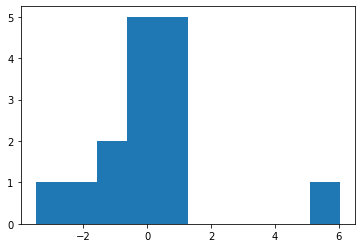

In [16]:
plt.hist(np.mean(zhat[0], axis=0))

(array([209325.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  16437.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

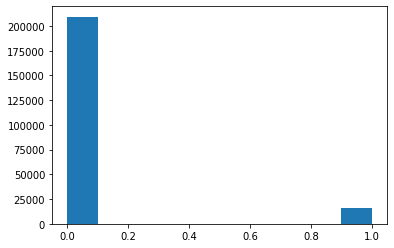

In [14]:
plt.hist(z)

In [15]:
#bw_indices = (group<3)

#X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
#    features[bw_indices,:], label[bw_indices], group[bw_indices]-1, test_size=0.30, random_state=0)

#y = y_train.astype(int).reshape(-1,1)
#z = group_train.reshape(-1,1)
#x = X_train[:,:-1]/np.max(X_train[:,:-1])

#for deg in range(1,10):
#
#    poly_reg=PolynomialFeatures(degree=deg)
#    x_poly = poly_reg.fit_transform(x)
#    coefficients, theta_average = linear_proxies(x_poly, y, z, 1000, 0.01)
#    overall_diff, model_diff, proxy_error = evaluate_proxy(x_poly, y, z, theta_average)
#    
#    print("Polynomial Degree: " + str(deg))
#    print("Overall diff: " + str(overall_diff))
#    print("Model diff: " + str(model_diff))
#    print("Proxy error: " + str(proxy_error))